# Exercises 2.1 to 2.6 from the QuantChallenge

Structure:
- Load and clean the data
- 2.1 Compute total energy generation (MWh)
- 2.2 Average over 24 hour period generation (MW) visualization
- 2.3 Average value for wind and solar (DA prices), comparison with DA prices
- 2.4 Largest/smallest renewable generation day; comparison with average DA price
- 2.5 Average hourly DA price on weedays and weekends
- 2.6 Simple hourly arbitrage strategy for a battery with instantaneous charge/discharge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Load Dataset

I found that of 35k values 4 have duplicated timestamp (time). Suspected data error.
As a part of data cleaning, I removed rows with duplicated timesteps.

In [2]:
# load dataset
df = pd.read_excel("./database/analysis_task_data.xlsx")
# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

print("Missing values:\n", df.isnull().sum())
print(f"unique time: {df['time'].is_unique}")
non_unique_values = df['time'].value_counts()[df['time'].value_counts() > 1].index.tolist()
print("Non-unique values:", non_unique_values)
print(f"Total values count {len(df)}")

df.drop_duplicates(subset='time', inplace=True, keep='first')


Missing values:
 hour                                                 0
time                                                 0
Wind Day Ahead Forecast [in MW]                      0
Wind Intraday Forecast [in MW]                       0
PV Day Ahead Forecast [in MW]                        0
PV Intraday Forecast [in MW]                         0
Day Ahead Price hourly [in EUR/MWh]                  0
Intraday Price Price Quarter Hourly  [in EUR/MWh]    0
Intraday Price Hourly  [in EUR/MWh]                  0
Imbalance Price Quarter Hourly  [in EUR/MWh]         0
dtype: int64
unique time: False
Non-unique values: [Timestamp('2021-10-31 02:45:00'), Timestamp('2021-10-31 02:30:00'), Timestamp('2021-10-31 02:15:00'), Timestamp('2021-10-31 02:00:00')]
Total values count 35040


# Task 2.1

> How much Wind/PV Power was forecasted to be produced in Germany in 2021 [in MWh] on Day Ahead (da) and on Intraday (id)?


The provided forecast values are given in MW for each quarter‐hour interval. Since 15 minutes is 0.25 hours, the energy (in MWh) delivered in one quarter hour is


Energy (MWh) = Power (MW)  * 15 / 60

So, to obtain the total forecasted energy over 2021, I sum up the quarter‐hour forecasts (after multiplying by 0.25). For example, for wind using the Day Ahead forecast:

In [3]:
# Create new columns for energy (MWh) per quarter hour:
df['wind_da_energy'] = df["Wind Day Ahead Forecast [in MW]"] * 0.25
df['wind_id_energy'] = df["Wind Intraday Forecast [in MW]"] * 0.25
df['pv_da_energy']   = df["PV Day Ahead Forecast [in MW]"] * 0.25
df['pv_id_energy']   = df["PV Intraday Forecast [in MW]"] * 0.25

# Sum over the year to get total energy in MWh
total_wind_da = df['wind_da_energy'].sum()
total_wind_id = df['wind_id_energy'].sum()
total_pv_da   = df['pv_da_energy'].sum()
total_pv_id   = df['pv_id_energy'].sum()

print("Task 2.1 Results:")
print(f"Total Wind Day Ahead Energy: {total_wind_da:,.0f} MWh")
print(f"Total Wind Intraday Energy: {total_wind_id:,.0f} MWh")
print(f"Total PV Day Ahead Energy:   {total_pv_da:,.0f} MWh")
print(f"Total PV Intraday Energy:   {total_pv_id:,.0f} MWh")

Task 2.1 Results:
Total Wind Day Ahead Energy: 115,375,868 MWh
Total Wind Intraday Energy: 113,460,050 MWh
Total PV Day Ahead Energy:   46,094,573 MWh
Total PV Intraday Energy:   46,689,892 MWh


# Task 2.2

> Show the average Wind/Solar production for 2021 over a 24‑h period for Intraday and Day Ahead (4 lines in one graph).

For this task I average the forecasted power (in MW) by the “hour of day.” (Although the forecasts are given for 15‑minute intervals, I can group by the hour in which they occur.) Then I plot the following four lines:

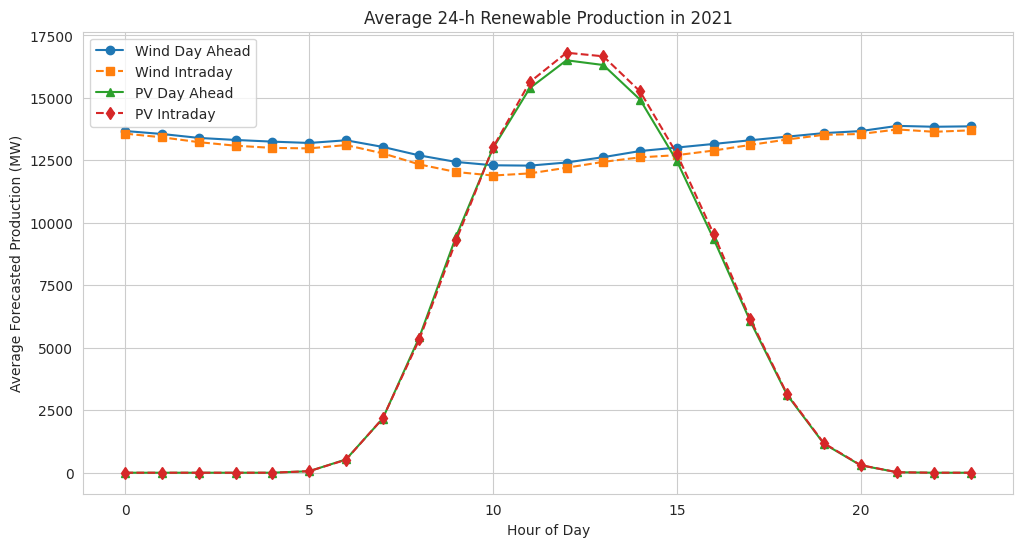

In [4]:
# Extract the hour from the timestamp
df['hour'] = df['time'].dt.hour

# Compute average production per hour (averaging the MW forecasts)
avg_wind_da = df.groupby('hour')["Wind Day Ahead Forecast [in MW]"].mean()
avg_wind_id = df.groupby('hour')["Wind Intraday Forecast [in MW]"].mean()
avg_pv_da   = df.groupby('hour')["PV Day Ahead Forecast [in MW]"].mean()
avg_pv_id   = df.groupby('hour')["PV Intraday Forecast [in MW]"].mean()

# Plotting the four time series
plt.figure(figsize=(12, 6))
plt.plot(avg_wind_da.index, avg_wind_da.values, label="Wind Day Ahead", linestyle='-', marker='o')
plt.plot(avg_wind_id.index, avg_wind_id.values, label="Wind Intraday", linestyle='--', marker='s')
plt.plot(avg_pv_da.index, avg_pv_da.values, label="PV Day Ahead", linestyle='-', marker='^')
plt.plot(avg_pv_id.index, avg_pv_id.values, label="PV Intraday", linestyle='--', marker='d')

plt.xlabel("Hour of Day")
plt.ylabel("Average Forecasted Production (MW)")
plt.title("Average 24-h Renewable Production in 2021")
plt.legend()
plt.grid(True)
plt.show()

# Task 2.3:

> What was the average value [in EUR/MWh] for Wind/Solar Power in 2021 using the da forecast and using da h prices?
__Definition__: The “average value” is defined as the average hourly revenue a Wind/PV farm owner would receive. This is computed as the production‐weighted average of the hourly Day Ahead price.

To compute this, I first aggregate the quarter‑hour forecasts to hourly production. (Remember that each quarter’s energy in MWh is forecast × 0.25.) Then, for each hour, the revenue is the hourly production (in MWh) times the Day Ahead price for that hour. Finally, the weighted average value is:

Weighted Average Value = sum(Production(MWh) * Price(Eur/MWh)) / sum(Production(MWh))

I do this separately for wind and PV. In addition, I compare with the simple (unweighted) average Day Ahead price.

In [5]:
# Create an hourly timestamp by flooring the 'time'
df['hour_ts'] = df['time'].dt.floor('h')

# Aggregate the quarter-hour data into hourly data:
# For production, sum the four quarters
hourly = df.groupby('hour_ts').agg({
    "Wind Day Ahead Forecast [in MW]": lambda x: (x * 0.25).sum(),
    "PV Day Ahead Forecast [in MW]":   lambda x: (x * 0.25).sum(),
    "Day Ahead Price hourly [in EUR/MWh]": "first"  # same for all quarters within an hour
})
hourly.rename(columns={
    "Wind Day Ahead Forecast [in MW]": "wind_da_energy_hour",
    "PV Day Ahead Forecast [in MW]":   "pv_da_energy_hour",
    "Day Ahead Price hourly [in EUR/MWh]": "da_price_hour"
}, inplace=True)

# Compute weighted average values:
total_wind_energy = hourly['wind_da_energy_hour'].sum()
total_pv_energy   = hourly['pv_da_energy_hour'].sum()

weighted_wind_value = (hourly['wind_da_energy_hour'] * hourly['da_price_hour']).sum() / total_wind_energy
weighted_pv_value   = (hourly['pv_da_energy_hour']   * hourly['da_price_hour']).sum() / total_pv_energy

# Compute the simple average Day Ahead price (across hours)
average_da_price = hourly['da_price_hour'].mean()

print("Task 2.3 Results:")
print(f"Weighted average revenue for Wind: {weighted_wind_value:.2f} EUR/MWh")
print(f"Weighted average revenue for PV:   {weighted_pv_value:.2f} EUR/MWh")
print(f"Simple average Day Ahead price:    {average_da_price:.2f} EUR/MWh")

Task 2.3 Results:
Weighted average revenue for Wind: 81.39 EUR/MWh
Weighted average revenue for PV:   76.89 EUR/MWh
Simple average Day Ahead price:    96.85 EUR/MWh


The weighted average revenues for wind (81 EUR/MWh) and PV (77 EUR/MWh) are lower than the simple average day-ahead price (97 EUR/MWh). This indicates that renewable generation is concentrated in hours with below-average prices.

In electricity markets, prices are set by the marginal cost of the most expensive source required to meet demand. Since wind and solar have near-zero marginal costs, their increased generation tends to coincide with lower prices. Conversely, during hours of lower renewable output, higher-cost dispatchable sources (e.g., gas or coal) are activated, driving prices above the average renewable revenue.


# Task 2.4

> Find the day with the highest renewable energy production and with the lowest renewable energy production in 2021. What were the average Day Ahead Price levels on these days? How do you explain the difference in prices?

Here I define total “renewable production” as the sum of the wind and PV Day Ahead production (in MWh). I first aggregate to a daily level and then identify the days with the maximum and minimum production. I then compute the average Day Ahead price for those days.

In [6]:
# Create a date column (without time)
df['date'] = df['time'].dt.date

# Aggregate daily production (summing the energy in MWh)
daily = df.groupby('date').agg({
    'wind_da_energy': 'sum',
    'pv_da_energy':   'sum',
    'Day Ahead Price hourly [in EUR/MWh]': 'mean' # since there are 4 equal values for each hour
})
daily['total_renewable'] = daily['wind_da_energy'] + daily['pv_da_energy']

# Identify the day with maximum and minimum renewable production:
max_prod_day = daily['total_renewable'].idxmax()
min_prod_day = daily['total_renewable'].idxmin()

max_day_price = daily.loc[max_prod_day, 'Day Ahead Price hourly [in EUR/MWh]']
min_day_price = daily.loc[min_prod_day, 'Day Ahead Price hourly [in EUR/MWh]']

print("\nTask 2.4 Results:")
print(
    f"Day with highest renewable production: {max_prod_day}, "
    f"total production = {daily.loc[max_prod_day, 'total_renewable']:.0f} MWh, "
    f"average da price = {max_day_price:.2f} EUR/MWh"
)
print(
    f"Day with lowest renewable production:  {min_prod_day}, "
    f"total production = {daily.loc[min_prod_day, 'total_renewable']:.0f} MWh, "
    f"average da price = {min_day_price:.2f} EUR/MWh"
)


Task 2.4 Results:
Day with highest renewable production: 2021-03-12, total production = 1088041 MWh, average da price = 22.29 EUR/MWh
Day with lowest renewable production:  2021-11-16, total production = 59199 MWh, average da price = 237.47 EUR/MWh


Interpretation:
Typically, on days with very high renewable production, the increased supply can drive prices down (supply–demand effects).
Conversely, on days with low renewable output, lower supply (or higher demand) may result in higher prices.

# Task 2.5

> What is the average hourly Day Ahead price during weekdays vs. during weekends. Why might average prices differ?

I use our previously created hourly data (in the hourly DataFrame) and add the weekday information. Then I compute average prices separately for weekdays and weekends.


In [7]:
hourly['weekday'] = hourly.index.dayofweek

# Define weekdays (Monday=0 to Friday=4) and weekends (Saturday=5, Sunday=6)
avg_price_weekdays = hourly.loc[hourly['weekday'] < 5, 'da_price_hour'].mean()
avg_price_weekends = hourly.loc[hourly['weekday'] >= 5, 'da_price_hour'].mean()

print("\nTask 2.5 Results:")
print(f"Average hourly Day Ahead price on weekdays: {avg_price_weekdays:.2f} EUR/MWh")
print(f"Average hourly Day Ahead price on weekends: {avg_price_weekends:.2f} EUR/MWh")


Task 2.5 Results:
Average hourly Day Ahead price on weekdays: 104.37 EUR/MWh
Average hourly Day Ahead price on weekends: 77.99 EUR/MWh


Electricity demand is generally lower on weekends due to reduced industrial and commercial activity)
which typically leads to lower prices compared to weekdays.

# Task 2.6

> How much revenue would you generate with a battery with a capacity of 1 MWh which you can fully charge and fully discharge (1 cycle) every day in 2021?

A simple arbitrage strategy is as follows. For each day, the battery can:

Charge (buy electricity) at the hour when the Day Ahead price is lowest.
Discharge (sell electricity) at the hour when the Day Ahead price is highest, after the charging time.
A realistic approach is to find the maximum price difference (profit) that can be obtained within each day subject to “buy before sell.” A common algorithm is to scan the day’s prices in order to record the lowest price seen so far and compute the difference with the current price. (If the best difference is negative, I assume no arbitrage is done that day, i.e. profit = 0.)

Below is a function that computes the maximum achievable profit (in EUR per MWh) for a given list of hourly prices in one day. I then apply it day‐by‐day and sum up the profits.

In [8]:
# First, I work with the hourly data I already built.
# Reset the index (hour_ts) to have a proper datetime column:
hourly = hourly.reset_index()
hourly['date'] = hourly['hour_ts'].dt.date

def max_daily_profit(prices):
    """Return maximum profit achievable with one buy (charge) and one sell (discharge)
       where buy must occur before sell."""
    min_price = float('inf')
    max_profit = 0.0
    for price in prices:
        if price < min_price: min_price = price
        profit = price - min_price
        if profit > max_profit: max_profit = profit
    return max_profit

# Group hourly prices by day and compute the maximum arbitrage profit for each day
daily_prices = hourly.groupby('date')['da_price_hour'].apply(list)
daily_profit = daily_prices.apply(max_daily_profit)

# For a battery of capacity 1 MWh, daily revenue (in EUR) equals the price difference times 1 MWh.
# Total revenue over the year:
total_battery_revenue = daily_profit.sum()

print("\nTask 2.6 Results:")
print(f"Total arbitrage revenue for a 1 MWh battery in 2021: {total_battery_revenue:.2f} EUR")


Task 2.6 Results:
Total arbitrage revenue for a 1 MWh battery in 2021: 27789.66 EUR
